# PBDR
March 2023



In [79]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import yaml

# Make inline plots in this notebook, make them reasonable sizes, and with legible font size
%matplotlib inline
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = [12, 8]

#sys.path   #use for debugging

In [88]:
# List what yaml files you have so you can choose one for the next line.
!ls yamls 

splatyaml = 'yamls/SPLAT_20230316.yaml'
chlatyaml = 'yamls/CHLAT_20230316.yaml'
satyaml =   'yamls/SAT_20230316.yaml'

CHLAT_20230122.yaml SAT_20230122.yaml   SPLAT_20230122.yaml
CHLAT_20230316.yaml SAT_20230316.yaml   SPLAT_20230316.yaml


In [89]:
# Check to see that things work
%run ../RunOnce.py yamls/SAT_20230316.yaml

20230316 : SAT  
                      LF_1       LF_2     MF_1_1     MF_2_1     MF_1_2     MF_2_2       HF_1       HF_2
 det_bandcenter :    25.745     38.745     85.000     95.000    144.995    155.000    226.995    285.500  
  det_bandwidth :     8.490     17.510     20.400     22.800     31.890     34.100     58.110     59.100  
 sys_bandcenter :    25.740     38.724     84.972     94.965    144.927    154.922    226.769    285.266  
  sys_bandwidth :     8.461     17.387     20.234     22.592     31.484     33.636     56.772     57.716  
 sky_bandcenter :    25.737     38.577     85.103     94.975    144.978    154.892    226.632    285.034  
  sky_bandwidth :     8.443     16.824     20.070     22.663     31.676     33.627     56.459     56.303  
          P_opt :     0.580      2.324      2.989      2.923      4.364      4.627      9.252     11.792  
         P_elec :     0.870      3.485      4.484      4.385      6.545      6.941     13.877     17.688  
          P_sat :     1

# Compare logistic and flat band P_optical for every telescope, every band.
(We need to decide whether the logistic bands are reasonable to proceed with)

We'll compare the detector bandwidth and the P_optical.  First, set the logistic parameters such that the 
logistic bands are very "square" to see that the results are nearly identical to the flat band calculation, 
then adjust those parameters to "more realistic" values and rerun to see how big the shifts are.

In [90]:
# these logistic parameter values seem to give reasonable "knees" by eye when compared 
# with Jeff McMahon's simulated module bands, for most of the band edges.

# Very square logistic bands:
#logistic_a = 20.0
#logistic_n = 0.3

# More realistic logistic bands:
logistic_a = 2.0
logistic_n = 0.7

yamlfiles = ['yamls/CHLAT_20230316.yaml', 'yamls/SPLAT_20230316.yaml', 'yamls/SAT_20230316.yaml']

for yamlfile in yamlfiles:
    Popts = {} # optical powers
    bw = {}    # bandwidths
    NETs = {}  # NETs
    print('\n-----------------')
    print(yamlfile)
    for band_method in ['flat','logistic']:
        Popts[band_method]={}
        bw[band_method]={}
        NETs[band_method]={}
        
        if 'channels' in sim:
            sim.clear()
        sim = yaml.safe_load(open(yamlfile))
    
        # yamls are correct for flat bands.
        # Adjust parameters to suit logistic band calculation if we're doing that.
        if band_method == 'logistic':
            for ch in sim['channels'].keys():
                _nuL = sim['channels'][ch]['nu_low']
                _nuH = sim['channels'][ch]['nu_high']
                sim['channels'][ch]['band_response']['method']='logistic'
                sim['channels'][ch]['band_response']['nu_lowedge'] = _nuL
                sim['channels'][ch]['band_response']['nu_highedge'] = _nuH
                sim['channels'][ch]['nu_low'] = 0.6*_nuL
                sim['channels'][ch]['nu_high'] = 1.4*_nuH
                sim['channels'][ch]['band_response']['a']=logistic_a
                sim['channels'][ch]['band_response']['n']=logistic_n

        run_optics(sim)
        run_bolos(sim)
        
        for ch in sim['channels'].keys():
            Popts[band_method][ch]=1e12*sim['outputs'][ch]['P_opt']
            bw[band_method][ch]=1e-9*sim['outputs'][ch]['det_bandwidth']
            NETs[band_method][ch]=1e6*sim['outputs'][ch]['NET_NC_total']

    print('P_opt          Flat       Logistic   Flat/Logistic')
    for ch in sim['channels'].keys():
        print('{0:9s}  {1:9.3f}  {2:9.3f}  {3:9.3f}'.format(ch, Popts['flat'][ch], Popts['logistic'][ch], Popts['flat'][ch]/Popts['logistic'][ch]))
 
    print()
    
    print('Det_Bandwidth  Flat       Logistic   Flat/Logistic')
    for ch in sim['channels'].keys():
        print('{0:9s}  {1:9.3f}  {2:9.3f}  {3:9.3f}'.format(ch, bw['flat'][ch], bw['logistic'][ch], bw['flat'][ch]/bw['logistic'][ch]))

    print()
    
    print('NET_cmb        Flat       Logistic   Flat/Logistic')
    for ch in sim['channels'].keys():
        print('{0:9s}  {1:9.3f}  {2:9.3f}  {3:9.3f}'.format(ch, NETs['flat'][ch], NETs['logistic'][ch], NETs['flat'][ch]/NETs['logistic'][ch]))

    


-----------------
yamls/CHLAT_20230316.yaml
P_opt          Flat       Logistic   Flat/Logistic
ULF            0.170      0.173      0.983
LF_1           0.205      0.206      0.993
LF_2           1.094      1.111      0.985
MF_1           1.495      1.517      0.986
MF_2           4.421      4.558      0.970
HF_1          12.326     12.430      0.992
HF_2          17.641     18.341      0.962

Det_Bandwidth  Flat       Logistic   Flat/Logistic
ULF            4.990      5.067      0.985
LF_1           6.490      6.548      0.991
LF_2          16.990     17.000      0.999
MF_1          28.990     29.003      1.000
MF_2          40.990     41.003      1.000
HF_1          57.990     58.003      1.000
HF_2          58.990     59.012      1.000

NET_cmb        Flat       Logistic   Flat/Logistic
ULF          413.217    392.162      1.054
LF_1         389.470    374.136      1.041
LF_2         236.157    229.382      1.030
MF_1         294.573    290.600      1.014
MF_2         328.104    32

# Discussion of flat vs logistic results

This is reassuring.   When the logistic band parameters are set to be "very square", most differences between flat and logistic are << 1%, with only one value (for ULF NETs) changing by (just a bit) more than 1%.

Moving to "more realistic" logistic band parameters, we actually see an improvement in NET by generally a couple percent.  I suspect that this is because the correlated (Bose) term in the photon noise favors adding more frequencies at reduced optical efficiency, ie you do better with double the bandwidth at half the efficiency.  The most important sanity-check here is that things are pretty stable.

So, I think it's okay to go ahead and use flat band parameters, since the Popt's are very similar, and the NET is a little conservative (higher than logistic).

We now proceed to find the PBDR-design results.  The first step is to find common Psats for the CHLAT and SPLAT.

# Find common Psats for the CHLAT and SPLAT
Using flat bands from yaml files.

In [91]:
Popts={'SPLAT':{},'CHLAT':{}, 'AVG':{}}
Psats={'SPLAT':{},'CHLAT':{}, 'AVG':{}}
NET_NCs = {'SPLAT':{},'CHLAT':{} }

#####--------------------------------------------------------------------------------------------------
##### Run SPLAT and CHLAT once to find Psats from actual optical power, then calculate avg of those.
# Run the SPLAT
sim = yaml.safe_load(open(splatyaml))
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['SPLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['SPLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['SPLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs

# Run the CHLAT
sim.clear()
sim = yaml.safe_load(open(chlatyaml))
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['CHLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['CHLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['CHLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs
    Popts['AVG'][ch] = (Popts['CHLAT'][ch] + Popts['SPLAT'][ch])/2
    Psats['AVG'][ch] = (Psats['CHLAT'][ch] + Psats['SPLAT'][ch])/2

print('P_opticals in pW')
print('         SPLAT   CHLAT    AVG')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:7.3f} {2:7.3f}  {3:7.3f}'.format(ch, 1e12*Popts['SPLAT'][ch], 1e12*Popts['CHLAT'][ch], 1e12*Popts['AVG'][ch]))

print()
print('P_sats in pW')
print('         SPLAT   CHLAT    AVG')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:7.3f} {2:7.3f}  {3:7.3f}'.format(ch, 1e12*Psats['SPLAT'][ch], 1e12*Psats['CHLAT'][ch], 1e12*Psats['AVG'][ch]))

print()
print('NET_NCs - with bespoke Psats in CHLAT and SPLAT')
print('          SPLAT    CHLAT')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:8.1f} {2:8.1f}'.format(ch, 1e6*NET_NCs['SPLAT'][ch], 1e6*NET_NCs['CHLAT'][ch]))

#####--------------------------------------------------------------------------------------------------
# Now re-run with fixed Psats, set to the average, and find and print the new NETs
# Run the SPLAT
sim.clear()
sim = yaml.safe_load(open(splatyaml))
sim['bolo_config']['psat_method']='specified'
for ch in sim['channels'].keys():
    sim['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['SPLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['SPLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['SPLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs
    
# Run the CHLAT
sim.clear()
sim = yaml.safe_load(open(chlatyaml))
sim['bolo_config']['psat_method']='specified'
for ch in sim['channels'].keys():
    sim['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim)
run_bolos(sim)
# Save the optical powers to a numpy array
for ch in sim['outputs'].keys():
    Popts['CHLAT'][ch]=sim['outputs'][ch]['P_opt']
    Psats['CHLAT'][ch]=sim['outputs'][ch]['P_sat']
    NET_NCs['CHLAT'][ch]=sim['outputs'][ch]['NET_NC_total']  # single detector NETs

print('\n----------------------')
print('Psats same in CHLAT and SPLAT')
print('P_sats in pW')
print('         SPLAT   CHLAT    AVG')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:7.3f} {2:7.3f}  {3:7.3f}'.format(ch, 1e12*Psats['SPLAT'][ch], 1e12*Psats['CHLAT'][ch], 1e12*Psats['AVG'][ch]))

print()
print('NET_NCs')
print('          SPLAT    CHLAT')
for ch in sim['outputs'].keys():
    print('{0:5s}: {1:8.1f} {2:8.1f}'.format(ch, 1e6*NET_NCs['SPLAT'][ch], 1e6*NET_NCs['CHLAT'][ch]))

    
#####--------------------------------------------------------------------------------------------------

    

P_opticals in pW
         SPLAT   CHLAT    AVG
ULF  :   0.114   0.170    0.142
LF_1 :   0.141   0.205    0.173
LF_2 :   0.901   1.094    0.997
MF_1 :   1.174   1.495    1.335
MF_2 :   2.965   4.421    3.693
HF_1 :   8.195  12.326   10.260
HF_2 :  11.845  17.641   14.743

P_sats in pW
         SPLAT   CHLAT    AVG
ULF  :   0.343   0.509    0.426
LF_1 :   0.423   0.615    0.519
LF_2 :   2.702   3.281    2.991
MF_1 :   3.523   4.486    4.005
MF_2 :   8.896  13.263   11.079
HF_1 :  24.584  36.979   30.781
HF_2 :  35.534  52.923   44.229

NET_NCs - with bespoke Psats in CHLAT and SPLAT
          SPLAT    CHLAT
ULF  :    398.0    413.2
LF_1 :    386.8    389.5
LF_2 :    256.7    236.2
MF_1 :    319.0    294.6
MF_2 :    290.8    328.1
HF_1 :    571.0    723.8
HF_2 :   1309.7   1780.0

----------------------
Psats same in CHLAT and SPLAT
P_sats in pW
         SPLAT   CHLAT    AVG
ULF  :   0.426   0.426    0.426
LF_1 :   0.519   0.519    0.519
LF_2 :   2.991   2.991    2.991
MF_1 :   4.005   4.

# Find and report the values we need for requirements (and other things), for each channel, each telescope.
This uses flat bands from yaml files, and the common SPLAT/CHLAT Psats from the cell above.

In [127]:
# SPLAT
#sim1.clear()
sim1 = yaml.safe_load(open(splatyaml))
sim1['bolo_config']['psat_method']='specified'
for ch in sim1['channels'].keys():
    sim1['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim1)
run_bolos(sim1)
print_full_table(sim1)

print('\n\n=======================================')

# CHLAT
#sim2.clear()
sim2 = yaml.safe_load(open(chlatyaml))
sim2['bolo_config']['psat_method']='specified'
for ch in sim2['channels'].keys():
    sim2['channels'][ch]['psat']=Psats['AVG'][ch]
run_optics(sim2)
run_bolos(sim2)
print_full_table(sim2)

print('\n\n=======================================')

# SAT
#sim3.clear()
sim3 = yaml.safe_load(open(satyaml))
run_optics(sim3)
run_bolos(sim3)
print_full_table(sim3)

20230316 : SPLAT
                       ULF       LF_1       LF_2       MF_1       MF_2       HF_1       HF_2
 det_bandcenter :    19.995     24.745     36.495     91.495    148.495    226.995    285.495  
  det_bandwidth :     4.990      6.490     16.990     28.990     40.990     57.990     58.990  
 sys_bandcenter :    20.178     24.999     37.526     92.783    149.704    227.836    285.787  
  sys_bandwidth :     4.073      5.233     12.449     22.807     34.997     53.865     57.631  
 sky_bandcenter :    20.176     24.998     37.430     92.864    149.740    227.698    285.556  
  sky_bandwidth :     4.087      5.242     13.078     22.869     35.153     53.973     58.149  
          P_opt :     0.114      0.141      0.901      1.174      2.965      8.195     11.845  
          n_avg :     1.723      1.323      2.115      0.671      0.735      0.935      1.058  
         P_elec :     0.312      0.378      2.091      2.830      8.114     22.587     32.384  
          P_sat :     0.42

# Calculate and write out (NET vs pwv), and (NET vs elevation) for each system.

# Reference cells - ignore below here.

In [125]:
print(sim1['outputs']['MF_2']['optics']['lyot'].keys())
sim1['outputs']['MF_2']['optics']['lyot']['effic']

dict_keys(['Pnu', 'P_opt', 'effic', 'effic_cumul'])


array([0.42755402, 0.42760392, 0.42765381, ..., 0.62170845, 0.62175198,
       0.6217955 ])

Channel output key descriptions:

- optics: each optical element is key, with scalars or numpy vectors of parameter vs frequency for each key under it.  For vectors, the matching frequency vector is in sim['outputs']['nu']. The parameters stored here include:
 - Pnu : a vector of the Watts/Hz this optical element, incident on the next element, for the AOmega of the detector system.
 - P_opt : a scalar (Watts), the contribution of this element to detector loading.
 - effic : a vector of the optical efficiency of this element as a function of frequency.
 - effic_cumul : a vector of the total optical efficiency from the detector through (not to) this element, as a function of frequency.
 
- sources:  each source listed in the yaml file (atmosphere and cmb in the example yaml), with the same info underneath it as for the optical elements listed above, ie scalar P_opt, and vectors Pnu, effic, and effic_cumul.

- nu : the frequency vector used for all calculations.

- det_bandwidth : the (photon) bandwidth of the detector response.
- det_bandcenter : the center of the detector response band.
- sys_bandwidth : the bandwidth of the system response from the detector to the last instrument element before the sky/atmosphere.
- sys_bandcenter : the center of the system response band.
- sky_bandwidth: the bandwidth of the response above the atmosphere.
- sky_bandcetner: the center of the response above the atmosphere.
- optics_effic_total: optical efficiency of the optics, vs frequency (a vector).
- optics_Pnu_total: optical loading in Watts/Hz of the optics, incident on the detector/horns, a vector.
- P_opt:  the total optical loading on the detector from all sources.
- Pnu_total:  the total frequency dependent loading on the detector in Watts/Hz from all sources, a vector.
- aperture_factor: for the photon noise horn correlation calculation.
- stop_factor:  for the photon noise horn correlation calculation.
- Photon noise parameters:  a whole mess of these are reported, because we're interested in the bose and poisson contributions, and in the corrections for horn correlations in an array.  If you see an "NC" (No Correlations) at the end of the name, it means that it is not corrected for horn-horn correlations and is appropriate for single-detector calculations.  If you see a "C" ("Correlations") at the end it means it is corrected for horn-horn correlations, and is appropriate for wafer calculations.  If you see a "v2" at the end that means it's an alternate formula I used as a crosscheck.  
- NET's are all in K*sqrt(sec);  "C" and "NC" at the end of a name mean the same thing as above.
- NEP's are all in Watts/sqrt(Hz);  "C" and "NC" at the end of a name mean the same thing as above.
- "corr_factor" is the correlation factor defined in the BoloCalc manual, which applies to the total NEP or NET in going from single detector to wafer values.
- dpdt : the dP_optical/dT_cmb, for conversion between NEP and NET_cmb.
- P_sat : the saturation power of the detector
- G_dynamic : dP_bolo/dT_bolo, ie the dynamic thermal conductance.
- F_link : the relevant factor by this name for the legs in the phonon NEP calculation.



# Example:  plot frequency dependent optical loading and efficiency for each band

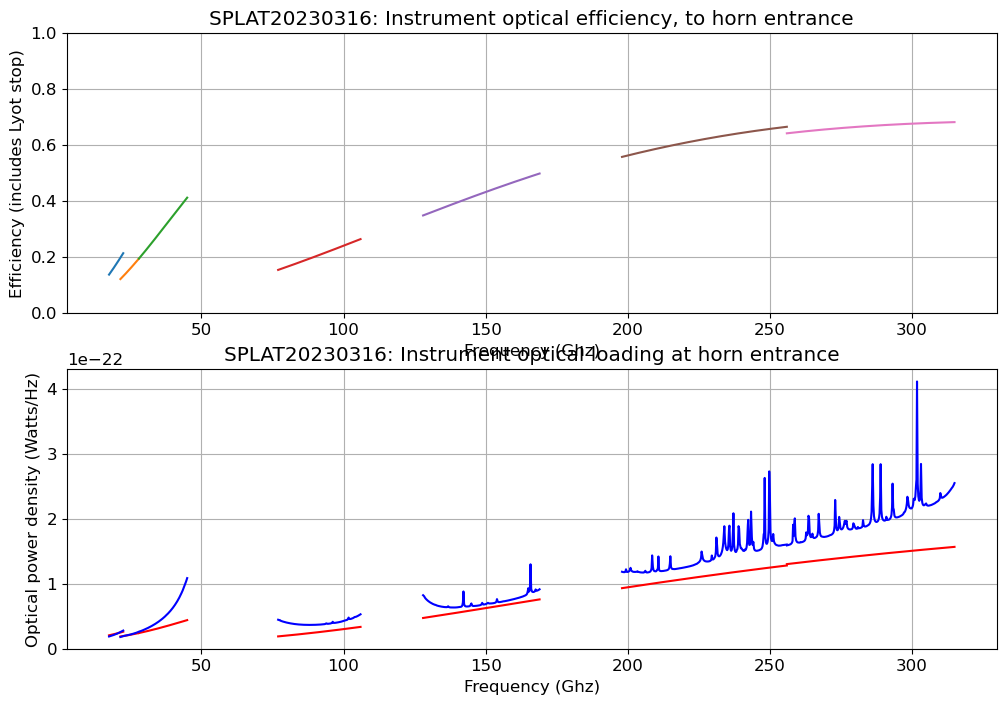

In [114]:
plt.rcParams.update({'font.size': 12})
plt.rcParams['figure.figsize'] = [12, 8]

sim = sim1 # SPLAT
#sim = sim2 # CHLAT
#sim = sim3 # SAT

#  Show the frequency-dependent optical efficiency of the each set of optics
plt.subplot(2,1,1)
#print('Instrument optical efficiency to horns:')
for ch in sim['channels'].keys():
    plt.plot(sim['outputs'][ch]['nu'],sim['outputs'][ch]['optics_effic_total'])
    #print('  {0} : {1:4.3f}'.format(ch,np.mean(sim['outputs'][ch]['optics_effic_total'])))
titlestring = sim['version']['name']+str(sim['version']['date'])+': Instrument optical efficiency, to horn entrance'
plt.title(titlestring)
plt.xlabel('Frequency (Ghz)')
plt.ylabel('Efficiency (includes Lyot stop)') 
plt.ylim(0,1)
plt.grid()

#  Show the frequency-dependent optical loading of the each set of optics
plt.subplot(2,1,2)
#print('Loading above horns:')
for ch in sim['channels'].keys():
    plt.plot(sim['outputs'][ch]['nu'],sim['outputs'][ch]['optics_Pnu_total'],'r')
    plt.plot(sim['outputs'][ch]['nu'],sim['outputs'][ch]['Pnu_total'],'b')
    #print('  {0} : {1:3.2e}'.format(ch,np.mean(sim['outputs'][ch]['optics_Pnu_total'])))
plt.xlabel('Frequency (Ghz)')
plt.ylabel('Optical power density (Watts/Hz)') 
titlestring = sim['version']['name']+str(sim['version']['date'])+': Instrument optical loading at horn entrance'
plt.title(titlestring)
plt.ylim(0)
plt.grid()

# Example:  plot optical power density loading of each source 

This is the Watts/Hz emitted into the next element, for a single moded detector.  

plotting avg Pnu
atmosphere
cmb


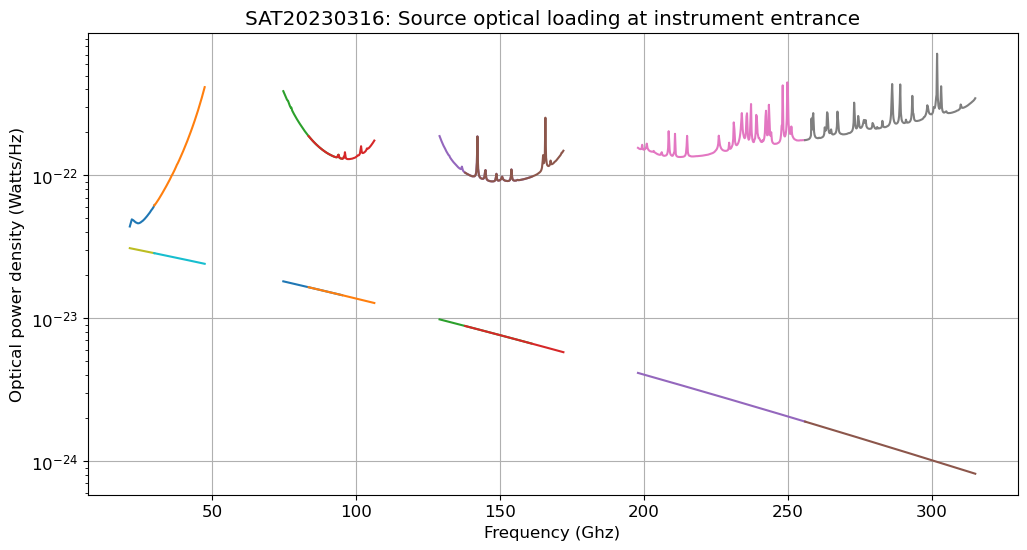

In [115]:
plt.rcParams['figure.figsize'] = [12, 6]

#sim = sim1 # SPLAT
#sim = sim2 # CHLAT
sim = sim3 # SAT

#  Calculate the atmospheric and cmb power incident on the front of the telescope.
#   (For use in requirements spreadsheet.)
print('plotting avg Pnu')
for src in reversed(sim['sources'].keys()):
    print(src)
    for ch in sim['channels'].keys():
        plt.semilogy(sim['outputs'][ch]['nu'],sim['outputs'][ch]['sources'][src]['Pnu'])
        #print('  {0} : {1:3.2e}'.format(ch,np.mean(sim['outputs'][ch]['sources'][src]['Pnu'])))

        
plt.xlabel('Frequency (Ghz)')
plt.ylabel('Optical power density (Watts/Hz)') 
titlestring = sim['version']['name']+str(sim['version']['date'])+': Source optical loading at instrument entrance'
plt.title(titlestring)
plt.grid()

Print out dp/dT_cmb at the detector, and at the telescope input

In [97]:
print('dp/dTcmb at')
print('        detector,  telescope_input')
for ch in sim['channels'].keys():
    dpdt_atdetector = sim['outputs'][ch]['dpdt']
    optics_eff = np.mean(sim['outputs'][ch]['optics_effic_total'])
    det_eff = np.mean(sim['outputs'][ch]['optics']['detector']['effic'])
    dpdt_atentrance = dpdt_atdetector/(optics_eff*det_eff)
    print('  {0} : {1:3.2e}   {2:3.2e}'.format(ch,dpdt_atdetector, dpdt_atentrance))


dp/dTcmb at
        detector,  telescope_input
  LF_1 : 5.12e-14   1.12e-13
  LF_2 : 1.10e-13   2.20e-13
  MF_1_1 : 9.58e-14   2.19e-13
  MF_2_1 : 1.06e-13   2.39e-13
  MF_1_2 : 1.21e-13   2.53e-13
  MF_2_2 : 1.18e-13   2.53e-13
  HF_1 : 9.05e-14   2.34e-13
  HF_2 : 4.71e-14   1.28e-13


Print out some photon noise related quantities.

In [98]:
ch = 'LF_1'
#sim['outputs'][ch].keys()
print('n avg:')
print(sim['outputs'][ch]['n_avg'])
print('Bose:')
print(sim['outputs'][ch]['NEP_photon_boseNC'])
print(sim['outputs'][ch]['NEP_photon_boseNC_v2'])
print('Poisson:')
print(sim['outputs'][ch]['NEP_photon_poissonNC'])
print(sim['outputs'][ch]['NEP_photon_poissonNC_v2'])
print('Total:')
print(sim['outputs'][ch]['NEP_photonNC'])
print(sim['outputs'][ch]['NEP_photonNC_v2'])

n avg:
4.03885786565476
Bose:
8.862234678241615e-18
8.862234678241615e-18
Poisson:
4.4279153595916385e-18
4.4279153595916385e-18
Total:
9.906848031737229e-18
9.906848031737229e-18


# Print optical powers and efficiencies for each element, for each channel.

In [11]:
# Print any on channel's optical elements table, basic properties
import jbolo_funcs as jbf
for ch in sim['channels'].keys():
    print('-----------------')
    jbf.print_optics(sim,ch)

-----------------
ULF
Element            Popt(pW)   Effic  Effic_cumul
detector       :    0.0000     0.6500    1.0000
objlens        :    0.0000     0.9933    0.6500
lyot           :    0.0204     0.2302    0.6456
lowpass        :    0.0001     0.9400    0.1486
colimlens      :    0.0000     0.9933    0.1397
fieldlens      :    0.0000     0.9933    0.1387
nylon_filt     :    0.0000     0.9899    0.1378
alumina_filt   :    0.0018     0.9761    0.1364
RTMLI_10       :    0.0055     0.9960    0.1332
window         :    0.0021     0.9891    0.1326
tertiary       :    0.0462     0.9795    0.1312
secondary      :    0.0011     0.9995    0.1285
primary        :    0.0011     0.9995    0.1284
atmosphere     :    0.0243     0.9881    0.1284
cmb            :    0.0198     0.0000    0.1268
P_opticsonly_total = 7.8444e-14
P_optical_total =  1.2258e-13
-----------------
LF_1
Element            Popt(pW)   Effic  Effic_cumul
detector       :    0.0000     0.6300    1.0000
objlens        :    0.0000 

# Print some detector info for each channel

In [42]:
# Print any on channel's optical elements table, basic properties
import jbolo_funcs as jbf
for ch in sim['channels'].keys():
    print('-----------------')
    jbf.print_detector(sim,ch)

-----------------
LF_1
  P_sat:          0.75
  F_link:         0.52
  G_dynamic:   2.10e-11
  NEP_phonon:     3.95
  NET_uncorr:   317.50
  NET_corr:     400.73
  Corr_factor:   1.262
  NET_NC_wafer:     36.23
  NET_C_wafer:     45.73
-----------------
LF_2
  P_sat:          4.18
  F_link:         0.52
  G_dynamic:   1.17e-10
  NEP_phonon:     9.32
  NET_uncorr:   255.59
  NET_corr:     266.97
  Corr_factor:   1.045
  NET_NC_wafer:     29.17
  NET_C_wafer:     30.46
-----------------
MF_1
  P_sat:          4.60
  F_link:         0.52
  G_dynamic:   1.29e-10
  NEP_phonon:     9.78
  NET_uncorr:   292.11
  NET_corr:     336.07
  Corr_factor:   1.151
  NET_NC_wafer:     11.11
  NET_C_wafer:     12.78
-----------------
MF_2
  P_sat:         12.51
  F_link:         0.52
  G_dynamic:   3.51e-10
  NEP_phonon:    16.12
  NET_uncorr:   327.31
  NET_corr:     332.14
  Corr_factor:   1.015
  NET_NC_wafer:     12.45
  NET_C_wafer:     12.63
-----------------
HF_1
  P_sat:         31.70
  F_link: 